# Ernesto Antonio Reyes Ramírez

# Procesamiento de Lenguaje Natural

# Tarea 6: Vencer al SVM

Estrategia: Lo que yo hice fue utilizar una técnica de machine learning llamada transferencia de conocimiento que consiste en tomar un modelo preentrenado previamente y ajustar sus parámetros con mis datos de entrenamiento par que aprenda a resolver específicamente la tarea que yo quiero (fine tuning). El modelo preentrenado que utilice fue un transformer llamado Robertuito, el cual está entrenado en tweets es español por lo que es una gran opción para tratar de resolver nuestra tarea.  

In [2]:
#Librerias útiles
import os
import re
from keras.preprocessing.text import Tokenizer
import csv
import numpy as np
import pandas as pd

In [1]:
#Cargamos los archivos de google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Función para leer nuestros archivos y procesarlos
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt.strip()]
        for label in f_truth:
            tr_y += [label.strip()]        
    return tr_txt, tr_y

### Procesamiento de los datos

In [4]:
#Cargamos los archivos de entrenamiento y validación.
tr_txt, tr_y = get_texts_from_file("/content/gdrive/MyDrive/MexA20/mex20_train.txt", "/content/gdrive/MyDrive/MexA20/mex20_train_labels.txt")
val_txt, val_y = get_texts_from_file("/content/gdrive/MyDrive/MexA20/mex20_val.txt", "/content/gdrive/MyDrive/MexA20/mex20_val_labels.txt")

In [5]:
tr_y = list(map(int, tr_y))
val_y = list(map(int, val_y))

Counter({0: 3759, 1: 1519})


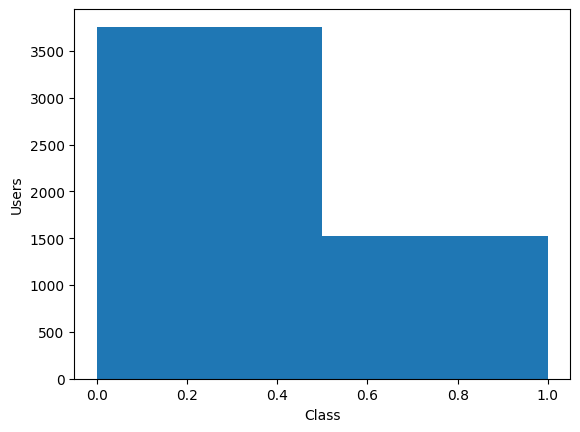

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users');
plt.xlabel('Class');

In [9]:
from datasets import load_dataset, list_datasets, load_metric,DatasetDict, Dataset

In [10]:
data = {'text': tr_txt, 'labels': tr_y}
train = pd.DataFrame(data)

In [11]:
data_val = {'text': val_txt, 'labels': val_y}
val = pd.DataFrame(data_val)

Cargamos las librerias de transformers y pysentimiento

In [ ]:
!pip install transformers

In [ ]:
!pip install pysentimiento

Cargamos el modelo de trnasformer Robertuito y su tokenizador

In [12]:
#from pysentimiento.preprocessing import preprocess_tweet
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-base-cased')

model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-base-cased", num_labels=2)

Some weights of the model checkpoint at pysentimiento/robertuito-base-cased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-cased and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight

In [13]:
#Cargamos la maétrica
metric = load_metric("accuracy")

<ipython-input-13-79730d3788fe>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [14]:
# Función para tokenizar el texto 
def encode(examples):
  return tokenizer(examples['text'],padding=True,truncation=True)

In [15]:
# Tokenizamos 
train = Dataset.from_pandas(train)
train=train.map(encode,batched=True,remove_columns=['text'])

Map:   0%|          | 0/5278 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
val = Dataset.from_pandas(val)
val=val.map(encode,batched=True,remove_columns=['text'])

Map:   0%|          | 0/587 [00:00<?, ? examples/s]

In [18]:
def compute_metrics(eval_pred):
  predictions,labels=eval_pred
  predictions=np.argmax(predictions, axis=1)
  return metric.compute(predictions=predictions, references=labels)

### Entrenamiento del modelo

In [19]:
from transformers import TrainingArguments, Trainer

In [21]:
metric_name = 'accuracy'
model_name ='pysentimiento/robertuito-base-cased-finetuning-agresividad'

args = TrainingArguments(
    model_name,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_eval_batch_size=8,
    per_device_train_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
trainer.evaluate()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.6441115140914917,
 'eval_accuracy': 0.6643952299829642,
 'eval_runtime': 5.6686,
 'eval_samples_per_second': 103.553,
 'eval_steps_per_second': 13.054}

In [24]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.363700,0.257275,0.899489
2,0.232700,0.366494,0.904600
3,0.161400,0.462236,0.916525
4,0.059000,0.517985,0.913118


TrainOutput(global_step=2640, training_loss=0.1740374140667193, metrics={'train_runtime': 396.5744, 'train_samples_per_second': 53.236, 'train_steps_per_second': 6.657, 'total_flos': 749179952365920.0, 'train_loss': 0.1740374140667193, 'epoch': 4.0})

In [25]:
# Guardar el modelo y el tokenizer en un directorio
directorio = '/content/gdrive/MyDrive'
trainer.save_model(directorio)
model.save_pretrained(directorio)
tokenizer.save_pretrained(directorio)

('/content/gdrive/MyDrive/tokenizer_config.json',
 '/content/gdrive/MyDrive/special_tokens_map.json',
 '/content/gdrive/MyDrive/tokenizer.json')

In [26]:
trainer.evaluate()

{'eval_loss': 0.46223586797714233,
 'eval_accuracy': 0.9165247018739353,
 'eval_runtime': 2.3499,
 'eval_samples_per_second': 249.798,
 'eval_steps_per_second': 31.491,
 'epoch': 4.0}

# Test

In [27]:
### Ahora procesamos el conjunto de test
test_txt, _= get_texts_from_file("/content/gdrive/MyDrive/MexA20/mex20_test_full.txt", "/content/gdrive/MyDrive/MexA20/mex20_val_labels.txt")

In [28]:
data_test = {'text': test_txt}
test = pd.DataFrame(data_test)

In [29]:
test = Dataset.from_pandas(test)
test=test.map(encode,batched=True,remove_columns=['text'])

Map:   0%|          | 0/1467 [00:00<?, ? examples/s]

In [30]:
# Calculamos las predicciones de nuestro modelo con el conjunto de prueba
predictions, labels, metrics = trainer.predict(test, metric_key_prefix="predict")

In [31]:
y_pred = np.argmax(predictions, axis=1)

In [32]:
#Finalmnete escribimos el archivo con nuestras predicciones
f = open("submission.csv", "w")
f.write("Id,Expected\n")
for pred, n in zip(y_pred, range(len(y_pred))):
    f.write(str(n) + "," + str(pred) + "\n")
f.close()